### Project 2

Authors: Lucas and Ari

In the following assignment, we're focusing again on the fine-food Amazon review network. We load it again and sample it in order to reduce its initial size for computational efficiency.

In [1]:
#Import packages and load data
import networkx as nx
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#Load Data
from google.colab import drive
drive.mount('/content/gdrive')
finefood = pd.read_csv('gdrive/My Drive/Colab Notebooks/Data 620/finefoods.csv')

finefood = finefood.sample(n=15000, random_state=958)

print(finefood.head())

Mounted at /content/gdrive
         productId          userId                 profileName helpfulness  \
206173  B00189Z02U   AU85YXK82B7LO     Lynn S. Stanley "Lynne"         3/3   
222514  B004E4CCSQ  A2UOHALGF2X77Q                   D. Hentze         0/0   
110400  B0001RVNLW  A10Q85BM42A2FH  Stephen C. Ellis "lab fan"         0/0   
415108  B001GVIUYA  A3SQJCRXHOQ8GF                      melois         2/2   
442625  B000FTP1IW  A2DQF17E46WPE4                P. C. Elliot         4/4   

        score        time                        summary  \
206173    3.0  1325462400                Chinese grocery   
222514    4.0  1328832000                      I like it   
110400    1.0  1198713600                       not good   
415108    5.0  1294617600   The best for Willy and Joey,   
442625    5.0  1235260800  Hawaiian Red Sea Salt (alaea)   

                                                     text  
206173  These are a very good choice for making Bubble...  
222514  I've tried two 

Next, we build the initial graph with all the nodes. We create a bipartite network where we have nodes for users and nodes for products. We then connect them by adding edges between the products and the users that reviewed them.

In [2]:
#Create a new graph
B = nx.Graph()

#Add user nodes with bipartite=0
B.add_nodes_from(finefood['userId'], bipartite=0)

#Add product nodes with bipartite=1
B.add_nodes_from(finefood['productId'], bipartite=1)

#Add edges between users and the products they reviewed
edges = [tuple(x) for x in finefood[['userId', 'productId']].to_numpy()]
B.add_edges_from(edges)

print("Initial Full Network")
print(f"Number of nodes: {B.number_of_nodes()}")
print(f"Number of edges: {B.number_of_edges()}")

user_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==0}
product_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==1}
print(f"Number of user nodes: {len(user_nodes)}")
print(f"Number of product nodes: {len(product_nodes)}")

Initial Full Network
Number of nodes: 22673
Number of edges: 14994
Number of user nodes: 13671
Number of product nodes: 9002


The full network shows that we have 13,671 user nodes and 9,002 products nodes. The number of edges being 14,994 hints at that only a small number of users likely reviewed more than one product. Next, we utilize the island method to extract the largest component of the network. For this, we can then also calculate the number of nodes and edges. To look at the largest component, we can identify products that are potentially in high-demand and likely well received. Additionally, we can identify the users that are more engaged. These could then also potentially act as future marketing targets, since they appear to be enjoying fine foods from Amazon.

In [4]:
#Find the connected components
components = nx.connected_components(B)

#Find the largest component
largest_component = max(components, key=len)

#Create a subgraph of the largest component
B_giant = B.subgraph(largest_component).copy()

print("\nReduced Network (Giant Component)")
print(f"Number of nodes in giant component: {B_giant.number_of_nodes()}")
print(f"Number of edges in giant component: {B_giant.number_of_edges()}")

giant_user_nodes = {n for n, d in B_giant.nodes(data=True) if d['bipartite']==0}
giant_product_nodes = {n for n, d in B_giant.nodes(data=True) if d['bipartite']==1}
print(f"Number of user nodes in giant component: {len(giant_user_nodes)}")
print(f"Number of product nodes in giant component: {len(giant_product_nodes)}")


Reduced Network (Giant Component)
Number of nodes in giant component: 1590
Number of edges in giant component: 1648
Number of user nodes in giant component: 1225
Number of product nodes in giant component: 365


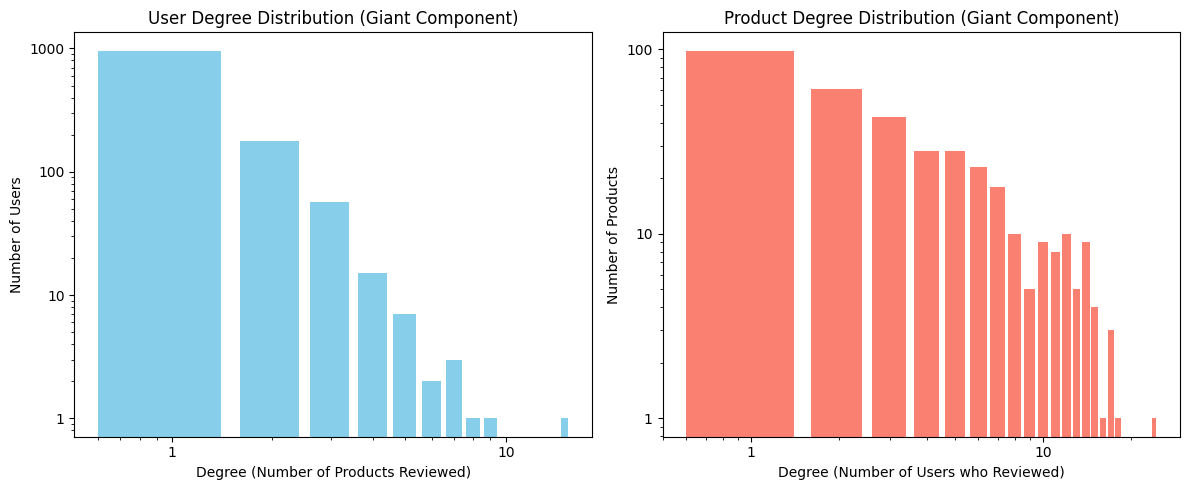

In [5]:
#Calculate degrees for each partition
user_degrees = [d for n, d in B_giant.degree() if n in giant_user_nodes]
product_degrees = [d for n, d in B_giant.degree() if n in giant_product_nodes]

#Plot Degree Distribution for Users
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(user_degrees, bins=range(1, max(user_degrees) + 2), align='left', rwidth=0.8, color='skyblue')
plt.title('User Degree Distribution (Giant Component)')
plt.xlabel('Degree (Number of Products Reviewed)')
plt.ylabel('Number of Users')
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}' if x >= 1 else ''))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y)}' if y >= 1 else ''))

#Plot Degree Distribution for Products
plt.subplot(1, 2, 2)
plt.hist(product_degrees, bins=range(1, max(product_degrees) + 2), align='left', rwidth=0.8, color='salmon')
plt.title('Product Degree Distribution (Giant Component)')
plt.xlabel('Degree (Number of Users who Reviewed)')
plt.ylabel('Number of Products')
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}' if x >= 1 else ''))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y)}' if y >= 1 else ''))

plt.tight_layout()
plt.show()

Above is plots for user and product degree distribution (the amount of reviews a users has or the amount of user reviews a product has). In our reduced network, there are way more user nodes than products: 1,225 user nodes vs 365 product nodes.

This is reflected in the different degrees as the users are very skewed towards low user engagement with almost 1,000 of these users only making 1 review. Product degree distribution, while yes the most common degree is 1 user review, is way more balanced. This is still a decent amount of products that have more than one review. This is also reflected in the stats below.

In [6]:
#stats
print("Users w/ 1 review:", user_degrees.count(1))
print("Products w/ 1 review:", product_degrees.count(1))

print("Max User Degree:", max(user_degrees))
print("Max Product Degree:", max(product_degrees))

print("Average User Degree:", np.median(user_degrees))
print("Average Product Degree:", np.median(product_degrees))

Users w/ 1 review: 959
Products w/ 1 review: 98
Max User Degree: 15
Max Product Degree: 24
Average User Degree: 1.0
Average Product Degree: 3.0


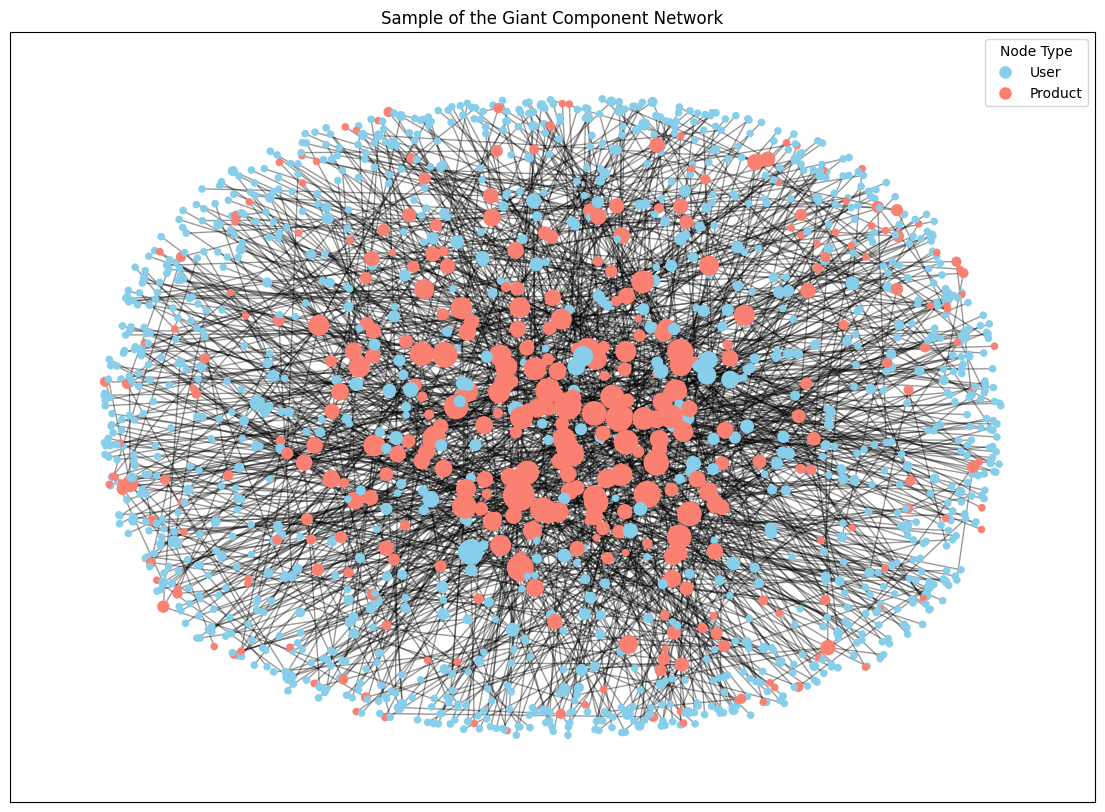

In [ ]:
#Plot Island
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(B_giant, k=0.3, iterations=50)

#Get node colors based on the bipartite attribute
node_colors = ['skyblue' if B_giant.nodes[n]['bipartite'] == 0 else 'salmon' for n in B_giant.nodes()]

#Size nodes by their degree in the giant component
node_sizes = [B_giant.degree(n) * 20 for n in B_giant.nodes()]

nx.draw_networkx_nodes(B_giant, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(B_giant, pos, alpha=0.4)

#Create custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='User', markerfacecolor='skyblue', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Product', markerfacecolor='salmon', markersize=10)]

plt.legend(handles=legend_elements, title="Node Type")
plt.title('Sample of the Giant Component Network')
plt.show()

The most striking finding is the dramatic reduction in size from the full network to the giant component. Only 7% of all nodes (1,590 out of 22,673) belong to the main interconnected network. This tells us that the review ecosystem is characterized by a small, central "core" of activity and a massive "periphery" of isolated, one-off interactions.
Conclusion: The "island method" was extremely effective. It successfully filtered out the enormous amount of "noise" from one-off reviews to reveal the essential structure of the network. These users are likely power users that are likely to purchase more in the future.